# CNNs and transfer learning

## Introduction

In the past lab we have used the high-level API of PyTorch to implement an MLP. We have seen how shifted images produced significantly worse results, while to the human eye the examples are equally recognisable.

In this lab we will use convolutional layers to increase translation invariance of images. We will start with implementing a convolutional model to perform classification on MNIST and then we will load a pretrained model and use transfer learning on a new dataset of fish images.


## Objectives
- Learn to create a simple CNN model in PyTorch
- Use torch cuda device to improve training performance 
- Understand and perform transfer learning using pretrained models

## Getting started

We will first import all necessary modules:

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


import numpy as np
import matplotlib.pyplot as plt

## Convolutional neural network

In order to build a CNN we use Convolutional layers from PyTorch. In the case of images we will need 2D convolutions.

## Exercise 1

Implement the following model using PyTorch:

```
- convolutional 1 input channel (grayscale images), 6 output channels, kernel 5x5, stride 1x1
- rectified linear unit
- max pooling 2x2
- convolutional 6 input channels, 16 output channels, kernel 5x5, stride 1x1
- rectified linear unit
- max pooling 2x2
- flatten
- linear 120 output units
- rectified linear unit
- linear 84 output units
- rectified linear unit
- linear 10 output units
```

**Note:** we must provide the input dimension of the first linear layer. This will depend on how the convolutional and pooling layers have downsampled the input images. By carefully looking at the docs of PyTorch we can compute the output dimensions before the linear layer. The lazy way is: 
- put an arbitrary value
- print the shape of `x` after every operation
- run a forward on a single batch (you may obtain a single batch from a dataloader with `next(iter(my_dataloader))`
- check where it fails and correct the input dimension of that layer  

For now you may simply put your best guess and we will correct it after running the next cell.

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
  
        self.net = nn.Sequential(
            nn.Conv2d(1, 6, 5), #1 i/p channel, 6 o/p channel, kernel 5x5
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(6, 16, 5), #6 i/p channel, 16 o/p channel, kernel 5x5
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(1), #flatten out the image
            nn.Linear(256, 120), #dense layer with 256 i/p and 120 o/p
            nn.ReLU(),
            nn.Linear(120, 84), #dense layer with 120 i/p and 84 o/p
            nn.ReLU(),
            nn.Linear(84, 10) #dense layer with 84 i/p and 10 o/p
        )
        

    def forward(self, x):
        
        return self.net(x)
     

model = Net() #initializing the model
print(model) 

x = torch.randn((1, 1, 28, 28))
model(x) #run the model on 1 sample image

Net(
  (net): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=256, out_features=120, bias=True)
    (8): ReLU()
    (9): Linear(in_features=120, out_features=84, bias=True)
    (10): ReLU()
    (11): Linear(in_features=84, out_features=10, bias=True)
  )
)


tensor([[-0.0824,  0.0781,  0.1350,  0.0195,  0.0469,  0.0534,  0.0076,  0.0410,
         -0.0714,  0.0667]], grad_fn=<AddmmBackward0>)

## Exercise 2
Create the datasets and data loaders for the MNIST dataset as done in the previous lab. Take the first batch and run a forward of the model correcting the input dimension of the first `Linear` layer.

In [ ]:

#downloading and creating the dataset
train_set = torchvision.datasets.MNIST(
    root="data/mnist",
    train=True,
    download=True,
    transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5, ))]) 
    
)


test_set = torchvision.datasets.MNIST(
    root="data/mnist",
    train=True,
    download=False,
    transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, ), (0.5, ))])
    )

inputs = next(iter(train_set))

output = model(torch.unsqueeze(inputs[0], 0))
print(output)

tensor([[-0.0756,  0.0404,  0.1093,  0.0158,  0.0277,  0.0521, -0.0328,  0.0608,
         -0.0782,  0.0269]], grad_fn=<AddmmBackward0>)


## Exercise 3

Train the model as done in the previous lab. Given that epochs take longer to compute with these models, we will print the average loss value every 1000 iterations. Write the train function so that every 1000 iterations it prints the average loss over these past 1000 iterations.

In [ ]:
%timeit
def train_model(model, dataloader, optimizer, criterion, n_epochs=1):
    model.train()

    for epoch in range(n_epochs):
        
        running_loss = 0.
        running_examples = 0
        for i, batch in enumerate(dataloader):
            
            with torch.no_grad():           
                optimizer.zero_grad()   #make the gradient of the optimizer 0

            yhat = model(batch[0]) #predict on the batch
            myloss = criterion(yhat, batch[1]) #compute loss
            myloss.backward() #compute gradient
            
            with torch.no_grad():
                optimizer.step() #optimizer step to update the parameters
            
            running_loss += myloss  #total summed loss
            
            if i%1000 == 0 and i!=0:
                print('ep: ', epoch, 'it: ', i, 'loss:',  (running_loss/(i+1)).item()) #calculate avg loss
          
def evaluate_model(model, dataloader):
    model.eval()

    correct = 0 #number of correct prediction
    total = 0 #total number of prediction

    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in dataloader:
            # calculate outputs by running images through the network
            yhat = model(data[0]) #predict on the batch

            #get the class using argmax and compare with the label. and compute the number of correct prediction
            correct += sum(torch.argmax(yhat, dim =1) == data[1]).item() 
            
            total+= data[0].shape[0] #total prediction in this batch
            
            # the class with the highest energy is what we choose as prediction

    accuracy = correct/total #accuracy
    return accuracy


model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

batch_size = 16

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)

train_model(model, train_loader, optimizer, criterion, n_epochs=2)
accuracy = evaluate_model(model, test_loader)
print(f'Accuracy of the network on the test images: {accuracy:.1%}')


ep:  0 it:  1000 loss: 1.8494575023651123
ep:  0 it:  2000 loss: 1.0736597776412964
ep:  0 it:  3000 loss: 0.7736287713050842
ep:  1 it:  1000 loss: 0.12280207127332687
ep:  1 it:  2000 loss: 0.10942317545413971
ep:  1 it:  3000 loss: 0.10474781692028046
Accuracy of the network on the test images: 97.5%


We notice that the change in architecture improves the accuracy obtained on the test set. However we also notice the training and testing takes longer. Convolutions are operations that can benefit significantly from GPU processing.

We will now learn how to move the data and operations to the GPU device to take advantage of its benefits.

The first thing to do is to obtain the GPU `device` if available, falling back to the CPU if the GPU is not available. This can be done with the following statement:

```
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
```

Then we may move the `nn.Module` that we want run in GPU:

```
model.to(device)
```

We must also move the data `inputs` and `labels` to the GPU before using them.

```
inputs, labels = inputs.to(device), labels.to(device)
```

**Note:** in Google's Collaboratory environment we may request running the Python kernel on a GPU. To do so go to the Menu > Runtime > Change runtime type. Only use this feature when needed to avoid using unnecessary ressources.

## Exercise 4

Re-train the model, this time on GPU.

In [ ]:
%timeit
def train_model(model, dataloader, optimizer, criterion, n_epochs=1, log_every=200, device='cpu'):
    
    model.to(device) #transfer the model to device

    model.train() 

    for epoch in range(n_epochs):
        
        running_loss = 0.
        running_examples = 0
        for i, batch in enumerate(dataloader):
            
            with torch.no_grad():           
                optimizer.zero_grad()
            
            batch[0], batch[1] = batch[0].to(device), batch[1].to(device)  #move the data to device
            yhat = model(batch[0]) #predict on the batch
            myloss = criterion(yhat, batch[1]) #compute the loss on the batch
            myloss.backward() #gradient
            
            with torch.no_grad():
                optimizer.step() #optimizer step to update parameters
            
            running_loss += myloss #accumulate ;pss
            
            if (i%log_every == 0) and (i!=0):
                print('ep: ', epoch, 'it: ', i, 'loss:',  (running_loss/(i+1)).item()) #avg loss
            
    

def evaluate_model(model, dataloader, device='cpu'):
    model.to(device) #mode the model to device
    
    model.eval()

    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in dataloader:
            
            # calculate outputs by running images through the network
            data[0], data[1] = data[0].to(device), data[1].to(device) #moving the data to device
            
            yhat = model(data[0]) #predict on the batch
            correct += sum(torch.argmax(yhat, dim =1) == data[1]).item() #calculate the correct number of prediction
            total+= data[0].shape[0] #total prediction
            
            # the class with the highest energy is what we choose as prediction

            

    accuracy = correct/total #accuracy
    return accuracy




#get the device = gpu if it is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = Net() #initialize model
criterion = nn.CrossEntropyLoss() #initialize loss function
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) #initialize optimizer

batch_size = 16 

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, num_workers=2)

train_model(model, train_loader, optimizer, criterion, n_epochs=2, device=device) #train model
accuracy = evaluate_model(model, test_loader, device=device) #calculate accuracy
print(f'Accuracy of the network on the 10000 test images: {accuracy:.1%}')


ep:  0 it:  200 loss: 2.297344923019409
ep:  0 it:  400 loss: 2.2834908962249756
ep:  0 it:  600 loss: 2.2332513332366943
ep:  0 it:  800 loss: 1.9559041261672974
ep:  0 it:  1000 loss: 1.6941431760787964
ep:  0 it:  1200 loss: 1.4884283542633057
ep:  0 it:  1400 loss: 1.3257012367248535
ep:  0 it:  1600 loss: 1.2019914388656616
ep:  0 it:  1800 loss: 1.0991780757904053
ep:  0 it:  2000 loss: 1.0162180662155151
ep:  0 it:  2200 loss: 0.9428874850273132
ep:  0 it:  2400 loss: 0.8811415433883667
ep:  0 it:  2600 loss: 0.8289902210235596
ep:  0 it:  2800 loss: 0.7833752632141113
ep:  0 it:  3000 loss: 0.7441861033439636
ep:  0 it:  3200 loss: 0.7095751762390137
ep:  0 it:  3400 loss: 0.677409291267395
ep:  0 it:  3600 loss: 0.6464534997940063
ep:  1 it:  200 loss: 0.13576900959014893
ep:  1 it:  400 loss: 0.13328887522220612
ep:  1 it:  600 loss: 0.14451947808265686
ep:  1 it:  800 loss: 0.1378294974565506
ep:  1 it:  1000 loss: 0.1387331336736679
ep:  1 it:  1200 loss: 0.1353185772895813

In this case the speed-up may not be too noticeable because the model is small. But we can now increase the number of convolutional filters without having a large impact on training time.

## Exercise 5

Try changing the number of filters of the first convolution to 16 and the next to 36.

In [ ]:
class Net(nn.Module):
    def __init__(self):
        
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 16, 5), #changing number of output filters to 16
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 36, 5), #changing number of ouput filters to 36
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(1),
            nn.Linear(576, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10)
        )
        
 

    def forward(self, x):
        return self.net(x)
 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = Net()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

train_model(model, train_loader, optimizer, criterion, n_epochs=2, device=device)
accuracy = evaluate_model(model, test_loader, device=device)
print(f'Accuracy of the network on the test images: {accuracy:.1%}')

model_without_augment = model #storing the model for later use

ep:  0 it:  200 loss: 2.289703607559204
ep:  0 it:  400 loss: 2.2578797340393066
ep:  0 it:  600 loss: 2.0734193325042725
ep:  0 it:  800 loss: 1.7336841821670532
ep:  0 it:  1000 loss: 1.4858932495117188
ep:  0 it:  1200 loss: 1.2982276678085327
ep:  0 it:  1400 loss: 1.153977870941162
ep:  0 it:  1600 loss: 1.0440690517425537
ep:  0 it:  1800 loss: 0.9547012448310852
ep:  0 it:  2000 loss: 0.8831199407577515
ep:  0 it:  2200 loss: 0.8197401762008667
ep:  0 it:  2400 loss: 0.7663646936416626
ep:  0 it:  2600 loss: 0.7206130623817444
ep:  0 it:  2800 loss: 0.6811063885688782
ep:  0 it:  3000 loss: 0.6470629572868347
ep:  0 it:  3200 loss: 0.616821825504303
ep:  0 it:  3400 loss: 0.5887823700904846
ep:  0 it:  3600 loss: 0.5614224076271057
ep:  1 it:  200 loss: 0.11853570491075516
ep:  1 it:  400 loss: 0.11163267493247986
ep:  1 it:  600 loss: 0.12444805353879929
ep:  1 it:  800 loss: 0.12012037634849548
ep:  1 it:  1000 loss: 0.1185658797621727
ep:  1 it:  1200 loss: 0.1150813922286033

We will now test whether using CNN allows us to improve performance on the test set of shifted images. 

## Exercise 6
Create a new `test_shifted_set` and `test_shifted_loader` where images are shifted 3 pixels to the right and plot the first image. Use the transforms API of PyTorch (e.g. `transforms.Lambda`).

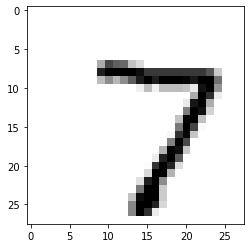

In [ ]:
#define the transformation
transform = transforms.Compose(
    [
     ### BEGIN SOLUTION
     transforms.ToTensor(),
     transforms.Normalize((0.5, ), (0.5, )),
     transforms.Lambda(lambda image: torch.roll(image, 3, 2)) #shift 3 pixel on the 2nd dimension of data
     
     ### END SOLUTION
    ])

#define the dataset
test_shifted_set = torchvision.datasets.MNIST('data/mnist', download=True, train=False, transform=transform)
batch_size = 16
test_shifted_loader = torch.utils.data.DataLoader(test_shifted_set, batch_size=batch_size)


plt.imshow(test_shifted_set[0][0][0], cmap='gray_r') #plot the first image of the shifted dataset
plt.show()

## Exercise 7

Test the performance of the previously trained model on the new test set.

In [ ]:

#evaluate the model with shifted data
accuracy = evaluate_model(model, test_shifted_loader, device=device)
print(f'Accuracy of the network on the shifted test images: {accuracy:.1%}')

#evaluate the model with non shifted data to compare the performance
accuracy = evaluate_model(model, test_loader, device=device)
print(f'Accuracy of the network on the non shifted test images: {accuracy:.1%}')


Accuracy of the network on the shifted test images: 82.9%
Accuracy of the network on the non shifted test images: 96.9%


## [Optional] Exercise 8

Compare the performance of an MLP vs CNN for shifts of increasing number of pixels.

In [ ]:
#downloading previously saved model state of the mlp from previous lab
!git clone https://github.com/AyonRRahman/mnist_model_deep_learning_assignment_saved_model.git

fatal: destination path 'mnist_model_deep_learning_assignment_saved_model' already exists and is not an empty directory.


In [ ]:
class MyMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28,100)
        self.fc2 = nn.Linear(100,10)

    def forward(self, x):
        x = torch.flatten(x,1)
        x = torch.sigmoid(self.fc1(x))
        x = self.fc2(x)
        return x


mymlp = MyMLP() #initialize the MLP
mymlp.load_state_dict(torch.load('/content/mnist_model_deep_learning_assignment_saved_model/mnist_model.pt')) #loading saved model states



device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#calculate accuracy of MLP model with non shifted image
accuracy = evaluate_model(mymlp, test_loader, device=device)
print(f'Accuracy of the network on the non shifted test images: {accuracy:.1%}')



Accuracy of the network on the non shifted test images: 90.8%


Accuracy of the CNN on the 0 pixel shifted test images: 97.0%
Accuracy of the MLP on the 0 pixel shifted test images: 91.2%
Accuracy of the CNN on the 1 pixel shifted test images: 96.6%
Accuracy of the MLP on the 1 pixel shifted test images: 85.3%
Accuracy of the CNN on the 2 pixel shifted test images: 93.9%
Accuracy of the MLP on the 2 pixel shifted test images: 66.3%
Accuracy of the CNN on the 3 pixel shifted test images: 82.9%
Accuracy of the MLP on the 3 pixel shifted test images: 44.1%
Accuracy of the CNN on the 4 pixel shifted test images: 59.9%
Accuracy of the MLP on the 4 pixel shifted test images: 22.6%
Accuracy of the CNN on the 5 pixel shifted test images: 38.7%
Accuracy of the MLP on the 5 pixel shifted test images: 11.5%
Accuracy of the CNN on the 6 pixel shifted test images: 23.6%
Accuracy of the MLP on the 6 pixel shifted test images: 7.1%
Accuracy of the CNN on the 7 pixel shifted test images: 13.3%
Accuracy of the MLP on the 7 pixel shifted test images: 6.8%
Accuracy o

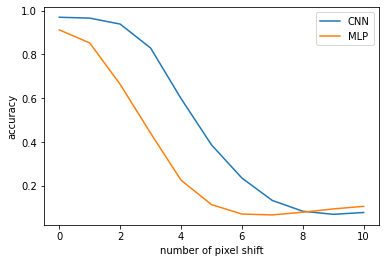

In [ ]:
#changing the number of shift of image from 0-10 and printing the result for both MLP and CNN
#MLP

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
pixel_shift = range(0,11) #we want to shift image from 0 to 10 pixel and see how the accuracy gets affected

CNN_acc = [] #to store the accuracies of CNN
MLP_acc = [] #to store the accuracies of MLP

for i in range(0,11):
    transform = transforms.Compose(
        [
        transforms.ToTensor(),
        transforms.Normalize((0.5, ), (0.5, )),
        transforms.Lambda(lambda image: torch.roll(image, i, 2)) #shift image by i pixel
        ])

    test_shifted_set = torchvision.datasets.MNIST('data/mnist', download=True, train=False, transform=transform) #create the dataset with shifted image
    batch_size = 16
    test_shifted_loader = torch.utils.data.DataLoader(test_shifted_set, batch_size=batch_size) 
    
    print('='*10)
    
    accuracy = evaluate_model(model, test_shifted_loader, device=device) #accuracy on the CNN
    print(f'Accuracy of the CNN on the {i} pixel shifted test images: {accuracy:.1%}')
    CNN_acc.append(accuracy)

    accuracy = evaluate_model(mymlp, test_shifted_loader, device=device) #accuracy on the MLP
    print(f'Accuracy of the MLP on the {i} pixel shifted test images: {accuracy:.1%}')
    MLP_acc.append(accuracy)


#plot the results
plt.plot(pixel_shift, CNN_acc, label = 'CNN')
plt.plot(pixel_shift, MLP_acc, label = 'MLP')
plt.legend()
plt.xlabel('number of pixel shift')
plt.ylabel('accuracy')
plt.show()

WE CAN SEE THAT BOTH CNN AND MLP LOSE ACCURACY AS THE IMAGES ARE BEING SHIFTED GRADUALLY. But the CNN is more robust to shift than the MLP.

## [Optional] Exercise 9

Propose a solution (and optionally implement it) to make the models even more robust to shifts?

Your reponse here

In [ ]:
'''
when we train the model we can feed some random augmented images to from the train set. 
We can randomly shift some images to some pixels while we are training the CNN model. 
By doing this the model will learn to classify even from the shifted images.
'''


'\nwhen we train the model we can feed some random augmented images to from the train set. \nWe can randomly shift some images to some pixels while we are training the CNN model. \nBy doing this the model will learn to classify even from the shifted images.\n'

In [ ]:
import random

#create dataset to have random augmentation(random shift in images)
transform = transforms.Compose(
    [
     transforms.ToTensor(),
     transforms.Normalize((0.5, ), (0.5, )),
     transforms.Lambda(lambda image: torch.roll(image, random.randint(0, 10), 2)) #randomo shift between 0-10 pixel
     ])

#create augmented train set 
augmented_train_set = torchvision.datasets.MNIST(
    root="data/mnist",
    train=True,
    download=True,
    transform =transform
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#deivce = "cpu"

model_with_augment = Net() #initialize the model
criterion = nn.CrossEntropyLoss() #initialize the loss
optimizer = optim.SGD(model_with_augment.parameters(), lr=0.001, momentum=0.9) #initialize the opimizer

batch_size = 16

aug_train_loader = torch.utils.data.DataLoader(augmented_train_set, batch_size=batch_size, num_workers=2)

train_model(model_with_augment, aug_train_loader, optimizer, criterion, n_epochs=2, device=device) #train the model with augmented data



ep:  0 it:  200 loss: 2.3026342391967773
ep:  0 it:  400 loss: 2.299410820007324
ep:  0 it:  600 loss: 2.2966673374176025
ep:  0 it:  800 loss: 2.2914204597473145
ep:  0 it:  1000 loss: 2.280705690383911
ep:  0 it:  1200 loss: 2.2395179271698
ep:  0 it:  1400 loss: 2.0935773849487305
ep:  0 it:  1600 loss: 1.9397739171981812
ep:  0 it:  1800 loss: 1.8017613887786865
ep:  0 it:  2000 loss: 1.6843714714050293
ep:  0 it:  2200 loss: 1.5753860473632812
ep:  0 it:  2400 loss: 1.475464940071106
ep:  0 it:  2600 loss: 1.39054274559021
ep:  0 it:  2800 loss: 1.3157066106796265
ep:  0 it:  3000 loss: 1.250465989112854
ep:  0 it:  3200 loss: 1.1914699077606201
ep:  0 it:  3400 loss: 1.1360492706298828
ep:  0 it:  3600 loss: 1.0855859518051147
ep:  1 it:  200 loss: 0.20463229715824127
ep:  1 it:  400 loss: 0.20474384725093842
ep:  1 it:  600 loss: 0.21763506531715393
ep:  1 it:  800 loss: 0.2084352970123291
ep:  1 it:  1000 loss: 0.20758192241191864
ep:  1 it:  1200 loss: 0.20246973633766174
ep: 

Accuracy of the CNN(trained with augmented data) on the 0 pixel shifted test images: 95.0%
Accuracy of the CNN(trained without augmented data) on the 0 pixel shifted test images: 97.0%
Accuracy of the MLP on the 0 pixel shifted test images: 91.2%
Accuracy of the CNN(trained with augmented data) on the 1 pixel shifted test images: 95.9%
Accuracy of the CNN(trained without augmented data) on the 1 pixel shifted test images: 96.6%
Accuracy of the MLP on the 1 pixel shifted test images: 85.3%
Accuracy of the CNN(trained with augmented data) on the 2 pixel shifted test images: 96.1%
Accuracy of the CNN(trained without augmented data) on the 2 pixel shifted test images: 93.9%
Accuracy of the MLP on the 2 pixel shifted test images: 66.3%
Accuracy of the CNN(trained with augmented data) on the 3 pixel shifted test images: 96.2%
Accuracy of the CNN(trained without augmented data) on the 3 pixel shifted test images: 82.9%
Accuracy of the MLP on the 3 pixel shifted test images: 44.1%
Accuracy of 

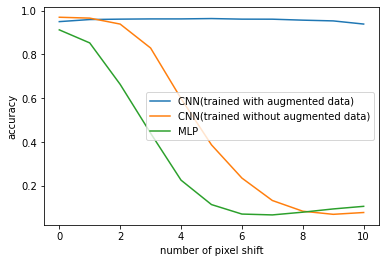

In [ ]:
#now we are going to apply gradual shift to the images in every epoch from 0-10 and compare the results of MLP, CNN and CNN_augmented
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
pixel_shift = range(0,11)
CNN_acc = []
CNN_aug = []
MLP_acc = []

for i in range(0,11):
    transform = transforms.Compose(
        [
        transforms.ToTensor(),
        transforms.Normalize((0.5, ), (0.5, )),
        transforms.Lambda(lambda image: torch.roll(image, i, 2))
        ])

    test_shifted_set = torchvision.datasets.MNIST('data/mnist', download=True, train=False, transform=transform)
    batch_size = 16
    test_shifted_loader = torch.utils.data.DataLoader(test_shifted_set, batch_size=batch_size)
    
    print('='*10)
    
    
    accuracy = evaluate_model(model_with_augment, test_shifted_loader, device=device)
    print(f'Accuracy of the CNN(trained with augmented data) on the {i} pixel shifted test images: {accuracy:.1%}')
    CNN_aug.append(accuracy)

    accuracy = evaluate_model(model, test_shifted_loader, device=device)
    print(f'Accuracy of the CNN(trained without augmented data) on the {i} pixel shifted test images: {accuracy:.1%}')
    CNN_acc.append(accuracy)

    accuracy = evaluate_model(mymlp, test_shifted_loader, device=device)
    print(f'Accuracy of the MLP on the {i} pixel shifted test images: {accuracy:.1%}')
    MLP_acc.append(accuracy)



#PLOT THE RESULTS
plt.plot(pixel_shift, CNN_aug, label = 'CNN(trained with augmented data)')
plt.plot(pixel_shift, CNN_acc, label = 'CNN(trained without augmented data)')
plt.plot(pixel_shift, MLP_acc, label = 'MLP')
plt.legend()
plt.xlabel('number of pixel shift')
plt.ylabel('accuracy')
plt.show()

**`Here we can see that CNN trained with augmented data is much more robust to image shift than the MLP and CNN trained without augmented data.`**

# Transfer learning

It is quite rare that we implement new models from scratch, specially when our target dataset is small.

We will often perform what is known as transfer learning: **start from well-established models pre-trained on large quantities of similar data**. For example, for natural image related tasks we will often start from a `ResNet` or `MobileNet`, whose weights have been trained on a classification task on ImageNet.

The model chosen to base our work on is often referred to as the **backbone**.

Depending on the task the pre-trained model may not be directly usable. Even when performing a classification task, the classes may not be the same, even the number of classes may vary. Therefore, for sure the output layer of the model may need to be modified (and re-trained).

PyTorch provides pre-trained models from [`torchvision.models`](https://pytorch.org/vision/stable/models.html) and from [PyTorch Hub](https://pytorch.org/hub/). Throughout this lab we will use the PyTorch Hub way.

For instance to download a [ResNet-18 model](https://pytorch.org/hub/pytorch_vision_resnet/) we would do:

```
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
```

To practice the methodology of transfer learning, we will use a small dataset provided by [here](https://homepages.inf.ed.ac.uk/rbf/fish4knowledge/GROUNDTRUTH/RECOG/)

We will do the following steps:
1. Download the data and untar it
2. Create a dataset object using [torchvision.datasets.ImageFolder](https://pytorch.org/vision/stable/datasets.html?highlight=imagefolder#torchvision.datasets.ImageFolder)
3. Split the dataset into train and test using [sklearn.model_selection.train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
4. Train several models on the data
    1. A simple custom made CNN model
    2. A ResNet-18 without pretrained weights
    3. A ResNet-18 with pretrained weights training only the last layer

When splitting the data into train and test we will do a 80% / 20% ratio per each class (stratified). <!--We notice in the dataset that consecutive images seem to be extracted often from the same video segment, therefore we will split data in consecutive chunks instead of shuffling it (random split).-->

## Exercise 10
Download the data and untar it. Using `wget` (run with the `-nc` flag to avoid redownloading unnecessarily multiple times) and `tar`. Bash commands in Colab and Jupyter must be preceded by a `!`.

In [ ]:
### BEGIN SOLUTION
#downloading the data
!wget https://homepages.inf.ed.ac.uk/rbf/fish4knowledge/GROUNDTRUTH/RECOG/Archive/fishRecognition_GT.tar -nc
### END SOLUTION

File ‘fishRecognition_GT.tar’ already there; not retrieving.



In [ ]:
#extracting the data
!tar xf fishRecognition_GT.tar

tar: A lone zero block at 997875


## Exercise 11
Create a `torchvision.datasets.ImageFolder` for the full fish recognition dataset and plot the first example.

In [ ]:
#mean and std Computed on a batch of 500 first batch of the dataset
mean = [2.1381161212921143, 0.07214844971895218, 0.08984410017728806]
std =  [0.05818214267492294, 2.06626558303833, 2.048595905303955]

#the mean and std is used to normalize the data
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
    ]
    )


#creating the dataset from the downloaded data and using the transformation
full_set = torchvision.datasets.ImageFolder(root='/content/fish_image', transform=transform)

### END SOLUTION

full_set.classes = [
                    'Dascyllus reticulatus',
                    'Plectroglyphidodon dickii',
                    'Chromis chrysura',
                    'Amphiprion clarkii',
                    'Chaetodon lunulatus',
                    'Chaetodon trifascialis',
                    'Myripristis kuntee',
                    'Acanthurus nigrofuscus',
                    'Hemigymnus fasciatus',
                    'Neoniphon sammara',
                    'Abudefduf vaigiensis',
                    'Canthigaster valentini',
                    'Pomacentrus moluccensis',
                    'Zebrasoma scopas',
                    'Hemigymnus melapterus',
                    'Lutjanus fulvus',
                    'Scolopsis bilineata',
                    'Scaridae',
                    'Pempheris vanicolensis',
                    'Zanclus cornutus',
                    'Neoglyphidodon nigroris',
                    'Balistapus undulatus',
                    'Siganus fuscescens'  	
]

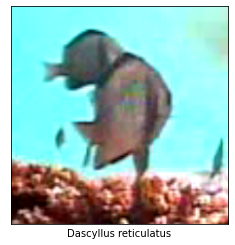

In [ ]:
### BEGIN SOLUTION
#to get back the image from normalized image , 
#We are using a inv transform Of the normalization we used on the image.
#then converting it to and PIL_img

import torchvision.transforms.functional as F
#take one first image from the dataset
img = full_set[0][0].detach()

#THE INVERSE TRANSFORM
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/std[0], 1/std[1], 1/std[2] ]),
                                transforms.Normalize(mean = [ -mean[0], -mean[1], -mean[2] ],
                                                     std = [ 1., 1., 1. ]),
                               ])

#transform the image back to original
img = invTrans(img)
img = F.to_pil_image(img)
plt.imshow(img)

#taking the label of the image from the set
label = full_set[0][1]

### END SOLUTION

plt.xticks([])
plt.yticks([])
plt.xlabel(full_set.classes[label])
plt.show()

## Exercise 12

Using the [`sklearn.model_selection.train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) and the labels from `full_set.targets` perform a stratified random split.

Then create the two new datasets `train_set` and `test_set` using [`torch.utils.data.Subset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Subset)

In [ ]:
from sklearn.model_selection import train_test_split

labels = list(full_set.targets)
indices = np.arange(len(labels))

#Random splits
###BEGIN SOLUTION

#GET THE IDS FOR SPLITTING(STRATIFIED) THE DATASET INTO TRAIN AND TEST SET 
train_idx, test_idx= train_test_split(
    np.arange(len(labels)),
    test_size=0.2, 
    random_state=42, 
    shuffle=True, 
    stratify=labels)


train_set = torch.utils.data.Subset(full_set, train_idx)
test_set = torch.utils.data.Subset(full_set, test_idx)
### END SOLUTION
print(np.unique(np.array(labels)[train_idx], return_counts=True))
print(np.unique(np.array(labels)[test_idx], return_counts=True))


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22]), array([9690, 2146, 2874, 3239, 2027,  152,  360,  174,  193,  239,   78,
        118,  145,   72,   34,  165,   39,   45,   23,   17,   13,   33,
         20]))
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22]), array([2422,  537,  719,  810,  507,   38,   90,   44,   48,   60,   20,
         29,   36,   18,    8,   41,   10,   11,    6,    4,    3,    8,
          5]))


In [ ]:
print(len(train_set))
print(len(test_set))

21896
5474


## Exercise 13

Compute on a batch of 500 random samples the mean and std deviation for each of the RGB channels. Set these in the `Normalize` transform of the full dataset of the previous cells in order to obtain a normalized version of the dataset.

In [ ]:
loader = torch.utils.data.DataLoader(train_set, batch_size=500, shuffle=True, num_workers=1)

# placeholders
ch_1_sum = 0
ch_2_sum = 0
ch_3_sum = 0

ch_1_sq_sum = 0
ch_2_sq_sum = 0
ch_3_sq_sum = 0

#calculating mean and std for each channel separately

# loop through images
for data in loader:
    print(data[0].shape)

    for images in data[0]:
        ch_1_sum += images[0].sum()
        ch_2_sum += images[1].sum()
        ch_3_sum += images[2].sum()

    # pixel count
    count = 500*224*224
    # mean and std
    ch1_mean = ch_1_sum/ count
    ch2_mean = ch_2_sum/ count
    ch3_mean = ch_3_sum/ count
    
    for images in data[0]:
        ch_1_sq_sum += ((images[0]-ch1_mean)**2).sum()
        ch_2_sq_sum += ((images[1]-ch1_mean)**2).sum()
        ch_3_sq_sum += ((images[2]-ch1_mean)**2).sum()

    
    
    break


# pixel count
count = 500*224*224
# mean and std

ch1_var  = (ch_1_sq_sum/ count)
ch1_std  = torch.sqrt(ch1_var)

ch2_var  = (ch_2_sq_sum/ count)
ch2_std  = torch.sqrt(ch2_var)

ch3_var  = (ch_3_sq_sum/ count)
ch3_std  = torch.sqrt(ch3_var)

# output
print('mean: '  + str([ch1_mean.item(), ch2_mean.item(), ch3_mean.item()]))
print('std:  '  + str([ch1_std.item(), ch2_std.item(), ch3_std.item()]))


torch.Size([500, 3, 224, 224])
mean: [-28.58338737487793, 0.261113703250885, 0.23914030194282532]
std:  [4.337935924530029, 28.844907760620117, 28.82295036315918]


## Exercise 14

Before tackling transfer learning with an existing model, we will revisit the simple CNN and training procedure we built for MNIST earlier in this lab and make a few modifications.

1. We must first adapt the input to 3 channels (RGB)
2. Adapt the output of the network to the number of classes in our task
3. Increase the number of convolutional layers to 3 (we have larger images) with number of filters `[6, 16, 32]`
4. Adapt the number of inputs of the first fully connected layer
5. Increase the batch size to `64` to improve training time

In [ ]:
class Net(nn.Module):
    ### BEGIN SOLUTION
    def __init__(self, num_of_class):
        
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 6, 5), #6 FILTERS
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(6, 16, 5), #16 FILTERS
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, 5), #32 FILTERS
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Flatten(1),
            nn.Linear(18432, 120),
            nn.ReLU(),
            
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, num_of_class)
        )
        
        ### END SOLUTION


    def forward(self, x):
        return self.net(x)
        
    ### END SOLUTION


def train_model(model, dataloader, optimizer, criterion, n_epochs=1, log_every=200, device='cpu'):
    ### BEGIN SOLUTION
    ## BEGIN SOLUTION
    
    model = model.to(device)

    model.train()

    for epoch in range(n_epochs):
        
        running_loss = 0.
        running_examples = 0
        for i, batch in enumerate(dataloader):
            
            with torch.no_grad():           
                optimizer.zero_grad()
            
            batch[0], batch[1] = batch[0].to(device), batch[1].to(device)
            
            yhat = model(batch[0])
            myloss = criterion(yhat, batch[1])
            myloss.backward()
            
            with torch.no_grad():
                optimizer.step()
            
            running_loss += myloss
            
            if (i%log_every == 0) and (i!=0):
                print('ep: ', epoch, 'it: ', i, 'loss:',  (running_loss.item()/(i+1)))

        with torch.no_grad():
            
            accuracy = evaluate_model(model, dataloader, device=device)
            print(f'End of Epoch {epoch}, train_accuracy {accuracy}')

    ### END SOLUTION



def evaluate_model(model, dataloader, device='cpu'):
    ## BEGIN SOLUTION
    model = model.to(device)
    
    model.eval()

    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in dataloader:
            
            # calculate outputs by running images through the network
            data[0], data[1] = data[0].to(device), data[1].to(device)
            
            yhat = model(data[0])
            correct += sum(torch.argmax(yhat, dim =1) == data[1]).item()
            total+= data[0].shape[0]
            
            
            

    accuracy = correct/total
    return accuracy
    ### END SOLUTION

batch_size = 64

#Creating the dataloader
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, pin_memory=True, num_workers=2, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, pin_memory=True, num_workers=2, shuffle = True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#instanciate the model with the number of classes
model = Net(len(full_set.classes))

#instanciate loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

#train and evaluate model
train_model(model, train_loader, optimizer, criterion, n_epochs=2, device=device, log_every=50)
accuracy = evaluate_model(model, test_loader, device=device)
print(f'Accuracy of the network on the test images: {accuracy:.1%}')

ep:  0 it:  50 loss: 2.1781710456399357
ep:  0 it:  100 loss: 1.8759721812635366
ep:  0 it:  150 loss: 1.6972731028171564
ep:  0 it:  200 loss: 1.6011943152887904
ep:  0 it:  250 loss: 1.5170070450619397
ep:  0 it:  300 loss: 1.4457333586936774
End of Epoch 0, train_accuracy 0.6564212641578371
ep:  1 it:  50 loss: 1.0165560105267692
ep:  1 it:  100 loss: 1.132826550172107
ep:  1 it:  150 loss: 1.0767723235073468
ep:  1 it:  200 loss: 1.0421554793172807
ep:  1 it:  250 loss: 1.014798532919105
ep:  1 it:  300 loss: 0.9805453988008721
End of Epoch 1, train_accuracy 0.735979174278407
Accuracy of the network on the test images: 73.1%


We will now create two utility function to help us visualize the outputs of an image classification model.

## Exercise 15

Create a function that takes an image, a model and list of classes and plots the image and a horizontal bar plot (using [`plt.barh`](https://matplotlib.org/stable/gallery/lines_bars_and_markers/barh.html)) showing the probabilities assigned to the top 10 predicted classes (using [`torch.topk`](https://pytorch.org/docs/stable/generated/torch.topk.html?highlight=topk#torch.topk)). Test it on the first image of the test set and using previous trained model.

**Note**: think of bringing back to the cpu and converting to numpy `my_np_array = my_torch_tensor.cpu().numpy()` torch tensors that are in the GPU.

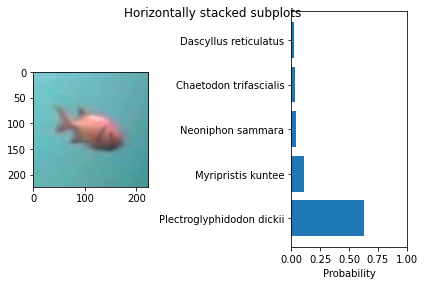

In [ ]:

def viz_image(image, model, classes, top=5, device='cpu'):
    
    assert image.ndim == 3, "Images are expected to have 3 dimensions: channels x height x width"
    was_training = model.training
    model.eval()
    with torch.no_grad():
        ### BEGIN SOLUTION
        image = image.to(device)
        if device=='cpu':
            model.cpu()
        else:
            model.cuda()
        
        #predict on the image
        probs = model(image.unsqueeze(0)) 
        
        #get the actual probability through softmax 
        softmax = torch.nn.Softmax(dim=1)
        probs = softmax(probs)
        
        #get the top k probable classes and their probability
        top_k_classes = torch.topk(probs,top)[1].cpu().squeeze().numpy()
        top_k_probs = torch.topk(probs,top)[0].cpu().squeeze().numpy()
        
        #get the top k class names
        top_k_class_names = [classes[i] for i in top_k_classes]
        
        y_pos = np.arange(len(top_k_class_names))
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.suptitle('Horizontally stacked subplots')
        
        #inverse tranform the image to get the actual image and show it
        img = invTrans(image)
        
        img = F.to_pil_image(img)
        ax1.imshow(img)
        
        #horizondtal bar plot of the top k classes and their probabilities
        ax2.barh(y_pos, top_k_probs)
        ax2.set_xlabel('Probability')
        plt.yticks(y_pos, labels=top_k_class_names)
        plt.xticks([0, 0.25, 0.5, 0.75, 1])
        ### END SOLUTION

    plt.tight_layout()
    model.train(was_training)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
image, label = test_set[0]
viz_image(image, model, full_set.classes, device=device)

## Exercise 16

Next we will visualize a batch of images and the class predicted by the model with it's probability in parentheses as their `xlabel`.
The function will also return the probabilites of all classes predicted for each image (tensor of `torch.float` with shape `(N, 1000)` where `N` is the number of images in the batch) and the class predicted by the model for each image (tensor of `torch.long` with shape `(N)`).

**Hint**: for create a grid of images consider the following snippet

```
fig = plt.figure(figsize=(10, 10))
for i, image in enumerate(images):
    ax = fig.add_subplot(n_rows, n_cols, i+1)

    # some code to normalize each image

    ax.imshow(...
```

**Note**: Normalize the pixels of each image between 0 and 1 before plotting it to obtain natural colors. Remember we need to do this, because each image was previously normalized to mean 0 and stddev 1 in order to be fed in the expected way by the model.

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f040e581160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.8/multiprocessi

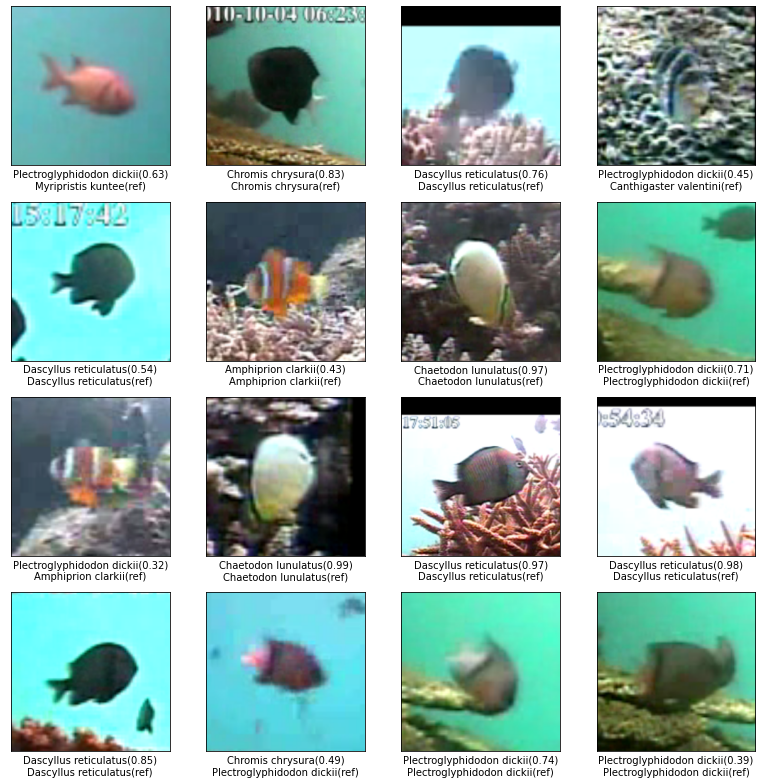

In [ ]:
import math
def viz_image_batch(images, model, classes, top=5, device='cpu', labels=None):
    assert images.ndim == 4, "Images are expected to have 4 dimensions: batch index x channels x height x width"
    model.to(device)
    
    #change data to device
    if device!='cpu':
        images = images.cuda()
    
    was_training = model.training
    model.eval()

    #get prediction of the odel
    predictions = model(images)

    #get the actual probability of the prediction using softmax
    softmax = torch.nn.Softmax(dim=1)
    probs = softmax(predictions)

    #class with max probability
    max_class = torch.argmax(probs, dim=1)

    #check how many rows and cols needed
    n_rows = math.ceil(math.sqrt(images.shape[0]))
    n_cols = n_rows

    with torch.no_grad():
        ### BEGIN SOLUTION
        fig = plt.figure(figsize=(11, 11))
        for i, image in enumerate(images):
            ax = fig.add_subplot(n_rows, n_cols, i+1)
            
            # some code to inverse transform each image

            img = invTrans(image)
            img = F.to_pil_image(img)
            #plot the image and their predicted and reference labels as the xlabel
            ax.imshow(img)
            ax.set_xticks([])
            ax.set_yticks([])
            cls = torch.argmax(probs[i]).item()
            cls_label = classes[cls]
            
            if labels==None: #if no label provided just show predicted class with probability
                ax.set_xlabel(f'{cls_label}({probs[i][cls].item():.2f})')
            else: #else show the predicted class with probability and the refernce label
                ref_label = labels[i]
                ref_label_name = classes[ref_label]
                ax.set_xlabel(f'{cls_label}({probs[i][cls].item():.2f})\n{ref_label_name}(ref)')
        
    
    

    plt.tight_layout()
    model.train(was_training)
    plt.show()
    
    return probs, max_class

test_loader = torch.utils.data.DataLoader(test_set, batch_size=16, pin_memory=True, num_workers=2)

images, labels = next(iter(test_loader))
probabilities, classes = viz_image_batch(images, model, full_set.classes, labels=labels, device=device)

# ResNet model

ResNets are a family of models that have been popularized by their performance in image classification tasks. We will start by downloading a [ResNet18 model](https://pytorch.org/vision/stable/models.html#torchvision.models.resnet18) (a ResNet model composed of 18 layers). Other variants exist with varying number of layers: `resnet34`, `resnet50`, `resnet101`, `resnet152`.

When using an existing model with our particular task, we must first ensure that the inputs of the model are correctly matched.
- The images must have a size compatible with the model

In the case of resnet18, it expects images of size 224x224. In Exercise 11 we had created our datasets for the underwater images in a way that images were scaled (and cropped when necessary) to this size. 

```
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    ...
    ]
```
- The images must have been normalised in an equal (or similar) way

In [torchvision documentation](https://pytorch.org/vision/stable/models.html#:~:text=All%20pre%2Dtrained,0.229%2C%200.224%2C%200.225%5D) we find that the models expect images to be normalized with zero mean and standard deviation of 1.  For the natural images in ImageNet, this corresponds to the following transform:

```
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
    ]
```

However in this lab we have recomputed the statistics of a subsample of our data, since underwater images may have significantly different statistics. 

- The output of the model may need to be modified to match our class set

At first we will not change the output, however the following exercises will require changing the final layer of the model to adapt to our own class set.

## Exercise 17
We will start by downloading a pre-trained `resnet18` and visualizing how it classifies our own images into the ImageNet classes.
**Note**: in order to show the class labels with which it was trained, we could download ImageNet using [`torchvision.datasets.ImageNet`](https://pytorch.org/vision/stable/datasets.html#imagenet) and access the `.classes` attribute of the dataset. However this would take a long unnecessary time and bandwidth, since only the labels are needed. PyTorch is currently revisiting the API of pretrained models ([see here](https://github.com/pytorch/vision/pull/4610)) to solve this and other issues. In the meantime we can download the class list from [https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt](https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt).  

In [ ]:
#download the imagenet classes
!wget -nc https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

File ‘imagenet_classes.txt’ already there; not retrieving.



In [ ]:
# Read the categories
with open("imagenet_classes.txt", "r") as f:
    imagenet_classes = [s.strip() for s in f.readlines()]

print(len(imagenet_classes))

1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


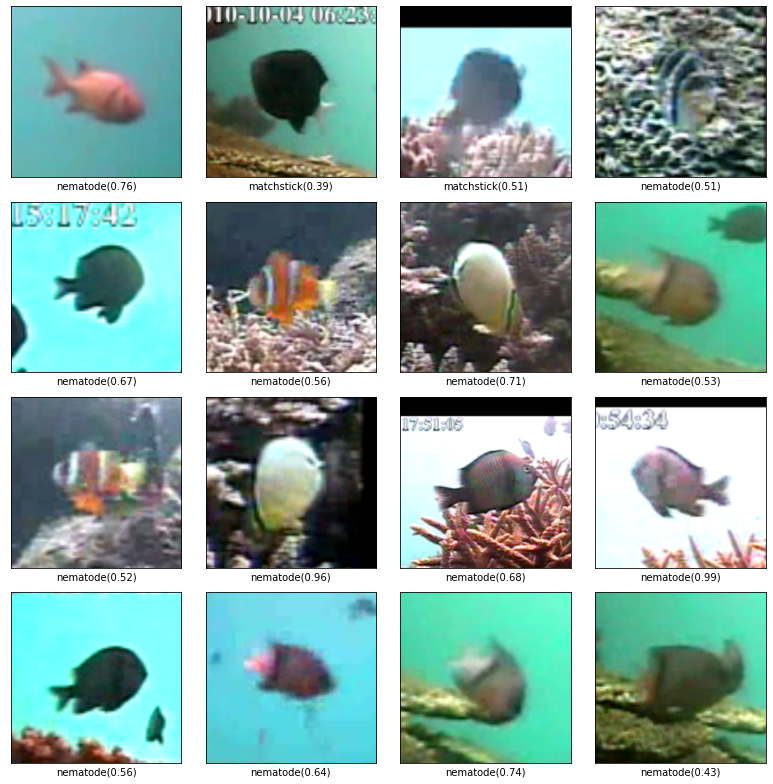

In [ ]:
#loading pretrained resnet18
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=16, pin_memory=True, num_workers=2)


images, labels = next(iter(test_loader))
probabilities, classes = viz_image_batch(images, model, imagenet_classes, device=device)

## Exercise 18

Comment on the results.


**Because we did not train the model with our data and the existing model has 1000 classes, thats why it is showing wrong label for our data. They are predicted as nematode which is one of the classes for which resnet was trained. **

We are now going to explore different settings of reusing the resnet-18 model. We will start with a non-pretrained model, by initialising the weights randomly and training all layers using the standard training loop that we did before.

To achieve this our first step is to **replace the output layer** in order to output logits for the correct number of classes (those found in our data).

We will first print the resnet model and identify the last layer.

## Exercise 19

Print a non-pretrained resnet18 model and identify the name of the output layer.

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)
print(model)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
'''the output layer is called fc'''

'the output layer is called fc'

`fc` stands for Fully Connected, and it is the last layer in the model.

In order to replace it we must first remember it's input dimensionality, which can be obtained using `fc.in_features`.

## Exercise 20

Replace the `fc` layer of the vanilla resnet-18 by another `Linear` layer with as many outputs as classes in our fish dataset. Train the resulting model for 2 epochs and show the obtained accuracy.

In [ ]:
model.fc.in_features

512

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)

### BEGIN SOLUTION
#changing the output layer as per our need
setattr(model,'fc',nn.Linear(512, len(full_set.classes))) #512 was the number of input feature for the last layer
 
### END SOLUTION

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

batch_size = 64

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, pin_memory=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, pin_memory=True, num_workers=2)

train_model(model, train_loader, optimizer, criterion, n_epochs=2, device=device, log_every=50)
accuracy = evaluate_model(model, test_loader, device=device)
print(f'Accuracy of the network on the test images: {accuracy:.1%}')

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


ep:  0 it:  50 loss: 2.663274129231771
ep:  0 it:  100 loss: 2.235347785572014
ep:  0 it:  150 loss: 2.0259522696994
ep:  0 it:  200 loss: 1.9112154073383085
ep:  0 it:  250 loss: 1.8325203823378362
ep:  0 it:  300 loss: 1.777561327151682
End of Epoch 0, train_accuracy 0.5107325538911217
ep:  1 it:  50 loss: 1.579025717342601
ep:  1 it:  100 loss: 1.5816160900758045
ep:  1 it:  150 loss: 1.5344845601265005
ep:  1 it:  200 loss: 1.4957859931300528
ep:  1 it:  250 loss: 1.4626593722765189
ep:  1 it:  300 loss: 1.4249790736607142
End of Epoch 1, train_accuracy 0.5695104128607965
Accuracy of the network on the test images: 57.0%


## Exercise 21

We will now try to leverage the large amount of natural imaging data from ImageNet, by using as backbone a pretrained resnet18 as starting point for training.


In [ ]:
#instantiating a pretrained model
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

### BEGIN SOLUTION
#changing the output layer as per our application 
setattr(model,'fc',nn.Linear(512, len(full_set.classes)))
 
### END SOLUTION

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

batch_size = 64

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, pin_memory=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, pin_memory=True, num_workers=2)

train_model(model, train_loader, optimizer, criterion, n_epochs=2, device=device, log_every=50)
accuracy = evaluate_model(model, test_loader, device=device)
print(f'Accuracy of the network on the test images: {accuracy:.1%}')

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


ep:  0 it:  50 loss: 2.408343296425015
ep:  0 it:  100 loss: 1.965003287438119
ep:  0 it:  150 loss: 1.7195743788157078
ep:  0 it:  200 loss: 1.5660675200656873
ep:  0 it:  250 loss: 1.445794823635147
ep:  0 it:  300 loss: 1.3529297077774605
End of Epoch 0, train_accuracy 0.8327548410668615
ep:  1 it:  50 loss: 0.9700605355057061
ep:  1 it:  100 loss: 0.8226066815971148
ep:  1 it:  150 loss: 0.7206356730682171
ep:  1 it:  200 loss: 0.6696393217020367
ep:  1 it:  250 loss: 0.6243335982242904
ep:  1 it:  300 loss: 0.5842876244224979
End of Epoch 1, train_accuracy 0.9095725246620388
Accuracy of the network on the test images: 91.2%


## Exercise 22
In some situations it may be faster and better in terms of acheived accuracy, to only train the last layer, while letting all other layers with their pretrained weights. To freeze a layer you may simply set the `require_grad` attribute of its parameters to `False`.

Sometimes it is still beneficial to perform an additional training phase in which all weights are updated for a couple of epochs. This is known as **fine tuning**. In this exercise we will only be training the inserted layer.

Implement this method and visualize the results on the first batch of test.

**Note**: You may iterate over all parameters of a model calling its `.parameters()` method.

**Note**: Make sure to not freeze the latest layer that you added.


In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
    
### BEGIN SOLUTION
setattr(model,'fc',nn.Linear(512, 23))

#the last layer has 23 output and the first dimension of their parameter is 23.
#we are freezing all layers exccept the layer with parameters with first dimension 23 
for params in model.parameters():
    if params.shape[0]==23:
        break
    else:
        params.requires_grad = False



### END SOLUTION

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

batch_size = 64

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, pin_memory=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, pin_memory=True, num_workers=2)

train_model(model, train_loader, optimizer, criterion, n_epochs=2, device=device, log_every=50)
accuracy = evaluate_model(model, test_loader, device=device)
print(f'Accuracy of the network on the test images: {accuracy:.1%}')

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


ep:  0 it:  50 loss: 1.7390946032954198
ep:  0 it:  100 loss: 1.4523362263594524
ep:  0 it:  150 loss: 1.2941105318385244
ep:  0 it:  200 loss: 1.2034317699830923
ep:  0 it:  250 loss: 1.134288164723917
ep:  0 it:  300 loss: 1.081112579649865
End of Epoch 0, train_accuracy 0.821245889660212
ep:  1 it:  50 loss: 0.7316713520124847
ep:  1 it:  100 loss: 0.7118141249854966
ep:  1 it:  150 loss: 0.6882039253285389
ep:  1 it:  200 loss: 0.6811874921049051
ep:  1 it:  250 loss: 0.670575024122261
ep:  1 it:  300 loss: 0.6621916507961743
End of Epoch 1, train_accuracy 0.851525392765802
Accuracy of the network on the test images: 84.8%


## Exercise 23

Visualize the first batch of 16 images and it's predicted class in test.

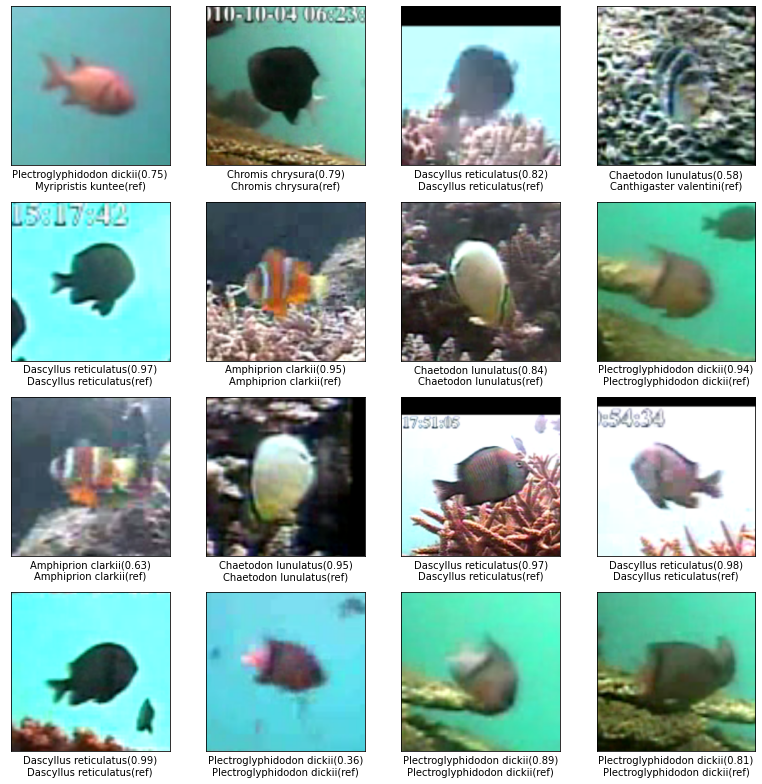

In [ ]:
### BEGIN SOLUTION
test_loader = torch.utils.data.DataLoader(test_set, batch_size=16, pin_memory=True, num_workers=2)

images, labels = next(iter(test_loader))
probabilities, classes = viz_image_batch(images = images,labels=labels, model = model, classes = full_set.classes, device=device, top = 5)

### END SOLUTION

## (optional) Exercise 24

Try with one (or all) of the following backbones: [`AlexNet`](https://pytorch.org/hub/pytorch_vision_alexnet/), [`VGG`](https://pytorch.org/hub/pytorch_vision_vgg/), [`MobileNetV2`](https://pytorch.org/hub/pytorch_vision_mobilenet_v2/)

In [ ]:
### BEGIN SOLUTION
#AlexNet
#initializing the model
Alex_model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
#setting the output layer as needed
in_feature = Alex_model.classifier[6].in_features
Alex_model.classifier[6] = nn.Linear(in_feature, 23) 

#freezing all layer except the last layer
for params in Alex_model.parameters():
    if params.shape[0]==23:
        break
    else:
        params.requires_grad = False

#initializing loss fn and optimizers
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(Alex_model.parameters(), lr=0.0001, momentum=0.9)

batch_size = 64
#loaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, pin_memory=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, pin_memory=True, num_workers=2)

#train and test the model
train_model(Alex_model, train_loader, optimizer, criterion, n_epochs=4, device=device, log_every=50)
accuracy = evaluate_model(Alex_model, test_loader, device=device)
print(f'Accuracy of the network on the test images: {accuracy:.1%}')

### END SOLUTION

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ep:  0 it:  50 loss: 2.108774521771599
ep:  0 it:  100 loss: 1.907838726987933
ep:  0 it:  150 loss: 1.799206260024317
ep:  0 it:  200 loss: 1.743539838648554
ep:  0 it:  250 loss: 1.7002568339921564
ep:  0 it:  300 loss: 1.6733955053792047
End of Epoch 0, train_accuracy 0.534846547314578
ep:  1 it:  50 loss: 1.2020223280962776
ep:  1 it:  100 loss: 1.1610844678217822
ep:  1 it:  150 loss: 1.1283107530202297
ep:  1 it:  200 loss: 1.1199233021902208
ep:  1 it:  250 loss: 1.10869789883435
ep:  1 it:  300 loss: 1.1002167863307206
End of Epoch 1, train_accuracy 0.6660120569967117
ep:  2 it:  50 loss: 1.0206725176642923
ep:  2 it:  100 loss: 1.0102417445418859
ep:  2 it:  150 loss: 0.9852225196282596
ep:  2 it:  200 loss: 0.9830818745627332
ep:  2 it:  250 loss: 0.9822903211373257
ep:  2 it:  300 loss: 0.9852810983245951
End of Epoch 2, train_accuracy 0.6959718670076727
ep:  3 it:  50 loss: 0.9460648929371553
ep:  3 it:  100 loss: 0.9477182520498143
ep:  3 it:  150 loss: 0.9213615569057844


In [ ]:
### BEGIN SOLUTION
#VGG
#initializing the model
VGG11_model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg11', pretrained=True)

#setting the output layer as needed
in_feature = VGG11_model.classifier[6].in_features
VGG11_model.classifier[6] = nn.Linear(in_feature, 23) 

#freezing all layer except the last layer
for params in VGG11_model.parameters():
    if params.shape[0]==23:
        break
    else:
        params.requires_grad = False

#initializing loss fn and optimizers
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(VGG11_model.parameters(), lr=0.0001, momentum=0.9)
batch_size = 64

#loaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, pin_memory=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, pin_memory=True, num_workers=2)

#train and test the model
train_model(VGG11_model, train_loader, optimizer, criterion, n_epochs=4, device=device, log_every=50)
accuracy = evaluate_model(VGG11_model, test_loader, device=device)
print(f'Accuracy of the network on the test images: {accuracy:.1%}')

### END SOLUTION

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ep:  0 it:  50 loss: 2.296525095023361
ep:  0 it:  100 loss: 2.0808295825920484
ep:  0 it:  150 loss: 1.9744822521083403
ep:  0 it:  200 loss: 1.9186132630305504
ep:  0 it:  250 loss: 1.8744636930792455
ep:  0 it:  300 loss: 1.8468530597876869
End of Epoch 0, train_accuracy 0.4931494336865181
ep:  1 it:  50 loss: 1.504903606339997
ep:  1 it:  100 loss: 1.4849844450997833
ep:  1 it:  150 loss: 1.4633543507152835
ep:  1 it:  200 loss: 1.4571757909670398
ep:  1 it:  250 loss: 1.4461683296112424
ep:  1 it:  300 loss: 1.4413747185488477
End of Epoch 1, train_accuracy 0.5580928023383266
ep:  2 it:  50 loss: 1.389061123717065
ep:  2 it:  100 loss: 1.3749360943784807
ep:  2 it:  150 loss: 1.3581124615195572
ep:  2 it:  200 loss: 1.356896395707012
ep:  2 it:  250 loss: 1.3505901929391808
ep:  2 it:  300 loss: 1.349747870055544
End of Epoch 2, train_accuracy 0.5919802703690171
ep:  3 it:  50 loss: 1.3269971959731157
ep:  3 it:  100 loss: 1.3153201565884127
ep:  3 it:  150 loss: 1.299746077581746

In [ ]:
### BEGIN SOLUTION
#VGG
#initializing the model
MobileNet_model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)

# setting the output layer as needed
in_feature = MobileNet_model.classifier[1].in_features
MobileNet_model.classifier[1] = nn.Linear(in_feature, 23) 

#freezing all layer except the last layer
for params in MobileNet_model.parameters():
    if params.shape[0]==23:
        break
    else:
        params.requires_grad = False

#initializing loss fn and optimizers
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(MobileNet_model.parameters(), lr=0.0001, momentum=0.9)
batch_size = 64

#loaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, pin_memory=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, pin_memory=True, num_workers=2)

#train and test the model
train_model(MobileNet_model, train_loader, optimizer, criterion, n_epochs=4, device=device, log_every=50)
accuracy = evaluate_model(MobileNet_model, test_loader, device=device)
print(f'Accuracy of the network on the test images: {accuracy:.1%}')

### END SOLUTION

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ep:  0 it:  50 loss: 2.5011652030196845
ep:  0 it:  100 loss: 2.1586143569190903
ep:  0 it:  150 loss: 1.9747965225320778
ep:  0 it:  200 loss: 1.8642704142859918
ep:  0 it:  250 loss: 1.7798831529351344
ep:  0 it:  300 loss: 1.7176915165593853
End of Epoch 0, train_accuracy 0.6605316039459262
ep:  1 it:  50 loss: 1.2847034229951746
ep:  1 it:  100 loss: 1.2645028746954285
ep:  1 it:  150 loss: 1.232937541229046
ep:  1 it:  200 loss: 1.2167211883696751
ep:  1 it:  250 loss: 1.1988248179158367
ep:  1 it:  300 loss: 1.1854282518557933
End of Epoch 1, train_accuracy 0.7626050420168067
ep:  2 it:  50 loss: 1.0811643413468903
ep:  2 it:  100 loss: 1.0676490859229966
ep:  2 it:  150 loss: 1.0441067929299461
ep:  2 it:  200 loss: 1.0363931988009172
ep:  2 it:  250 loss: 1.0260774528837775
ep:  2 it:  300 loss: 1.018783214480378
End of Epoch 2, train_accuracy 0.7885001826817684
ep:  3 it:  50 loss: 0.9684193181056603
ep:  3 it:  100 loss: 0.9574040327921952
ep:  3 it:  150 loss: 0.936669457037

## (optional) Exercise 25

Perform fine tuning on one (or more) of the models we have done.

In [ ]:
### BEGIN SOLUTION
#unfreezing all the layers to fine tune the AlexNet model

for params in Alex_model.parameters():
    params.requires_grad = True

optimizer = optim.SGD(Alex_model.parameters(), lr=0.0001, momentum=0.9)

#tuning for 2 epochs
train_model(Alex_model, train_loader, optimizer, criterion, n_epochs=2, device=device, log_every=50)
accuracy = evaluate_model(Alex_model, test_loader, device=device)
print(f'Accuracy of the fine tuned AlexNet on the test images: {accuracy:.1%}')

### END SOLUTION

ep:  0 it:  50 loss: 1.2146790448357077
ep:  0 it:  100 loss: 1.0554123680190284
ep:  0 it:  150 loss: 0.9351732872969267
ep:  0 it:  200 loss: 0.8712349507346082
ep:  0 it:  250 loss: 0.8184023549357259
ep:  0 it:  300 loss: 0.7721289447771751
End of Epoch 0, train_accuracy 0.8610705151625868
ep:  1 it:  50 loss: 0.4240879358029833
ep:  1 it:  100 loss: 0.3890087014377707
ep:  1 it:  150 loss: 0.3694475439210601
ep:  1 it:  200 loss: 0.3667197156308302
ep:  1 it:  250 loss: 0.35502353987370827
ep:  1 it:  300 loss: 0.3453066752994575
End of Epoch 1, train_accuracy 0.9117190354402631
Accuracy of the fine tuned AlexNet on the test images: 90.8%


In [ ]:
### BEGIN SOLUTION
#unfreezing all the layers to fine tune the VGG11 model

for params in VGG11_model.parameters():
    params.requires_grad = True

optimizer = optim.SGD(VGG11_model.parameters(), lr=0.0001, momentum=0.9)

#tuning for 2 epochs
train_model(VGG11_model, train_loader, optimizer, criterion, n_epochs=2, device=device, log_every=50)
accuracy = evaluate_model(VGG11_model, test_loader, device=device)
print(f'Accuracy of the fine tuned VGG11 on the test images: {accuracy:.1%}')

### END SOLUTION

ep:  0 it:  50 loss: 1.434206345502068
ep:  0 it:  100 loss: 1.2971664277633819
ep:  0 it:  150 loss: 1.2061371455918874
ep:  0 it:  200 loss: 1.1336682827318485
ep:  0 it:  250 loss: 1.0783992934511952
ep:  0 it:  300 loss: 1.0256241199582121
End of Epoch 0, train_accuracy 0.7618286445012787
ep:  1 it:  50 loss: 0.6126425873999503
ep:  1 it:  100 loss: 0.5800165988431119
ep:  1 it:  150 loss: 0.5398051786106943
ep:  1 it:  200 loss: 0.523096606506044
ep:  1 it:  250 loss: 0.5043125532537818
ep:  1 it:  300 loss: 0.4850917068430752
End of Epoch 1, train_accuracy 0.8825356229448301
Accuracy of the fine tuned VGG11 on the test images: 88.2%


In [ ]:
### BEGIN SOLUTION
#unfreezing all the layers to fine tune the MobileNet model

for params in MobileNet_model.parameters():
    params.requires_grad = True

optimizer = optim.SGD(MobileNet_model.parameters(), lr=0.0001, momentum=0.9)

#tuning for 2 epochs
train_model(MobileNet_model, train_loader, optimizer, criterion, n_epochs=2, device=device, log_every=50)
accuracy = evaluate_model(MobileNet_model, test_loader, device=device)
print(f'Accuracy of the fine tuned MobileNet on the test images: {accuracy:.1%}')

### END SOLUTION

ep:  0 it:  50 loss: 0.8667301851160386
ep:  0 it:  100 loss: 0.8141275538076268
ep:  0 it:  150 loss: 0.76103028556369
ep:  0 it:  200 loss: 0.7307361204232743
ep:  0 it:  250 loss: 0.7014268365989168
ep:  0 it:  300 loss: 0.6771159124532807
End of Epoch 0, train_accuracy 0.8595177201315308
ep:  1 it:  50 loss: 0.6554977566588158
ep:  1 it:  100 loss: 0.5800519508890586
ep:  1 it:  150 loss: 0.5283589647305722
ep:  1 it:  200 loss: 0.49909331668075635
ep:  1 it:  250 loss: 0.47000301406677975
ep:  1 it:  300 loss: 0.44416692486633097
End of Epoch 1, train_accuracy 0.9226799415418341
Accuracy of the fine tuned MobileNet on the test images: 92.1%
